In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Function to reconstruct full TCI image from tiles
def reconstruct_full_image_from_tiles(tile_dir, tile_size=512):
    tile_files = [f for f in os.listdir(tile_dir) if f.endswith('.jpg')]

    # Sort the tile files based on their y and x position in the filename
    tile_files.sort(key=lambda f: (int(f.split('_')[-2]), int(f.split('_')[-1].replace('.jpg', ''))))

    # Extract the max y and x to determine the full image size
    max_y = max(int(f.split('_')[-2]) for f in tile_files)
    max_x = max(int(f.split('_')[-1].replace('.jpg', '')) for f in tile_files)

    # Calculate the size of the full image
    full_height = max_y + tile_size
    full_width = max_x + tile_size

    # Initialize an empty array for the full image
    full_image = np.zeros((full_height, full_width, 3), dtype=np.uint8)

    # Place each tile in its correct position in the full image
    for tile_file in tile_files:
        # Extract y and x from the filename
        y = int(tile_file.split('_')[-2])
        x = int(tile_file.split('_')[-1].replace('.jpg', ''))

        # Load the tile
        tile_path = os.path.join(tile_dir, tile_file)
        tile = cv2.imread(tile_path)

        # Place the tile in the full image
        full_image[y:y + tile_size, x:x + tile_size] = tile

    return full_image

In [4]:
# Function to perform image matching using SIFT and BFMatcher
def match_images(image1, image2):
    # Convert to grayscale for SIFT
    gray1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

    # Initialize the SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    # Use BFMatcher to match descriptors
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test as per Lowe's paper
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Draw matches
    matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return matched_image

In [5]:
# Function to visualize the matched keypoints
def visualize_matched_image(matched_image):
    plt.figure(figsize=(15, 15))
    plt.imshow(matched_image)
    plt.title('Matched Keypoints')
    plt.axis('off')
    plt.show()

In [6]:
# Main function to run image matching on reconstructed TCI images
def run_image_matching_on_reconstructed_tci(dataset_path1, dataset_path2):
    # Reconstruct the two TCI images from tiles
    image1 = reconstruct_full_image_from_tiles(dataset_path1)
    image2 = reconstruct_full_image_from_tiles(dataset_path2)

    # Perform image matching
    matched_image = match_images(image1, image2)

    # Visualize the matched keypoints
    visualize_matched_image(matched_image)

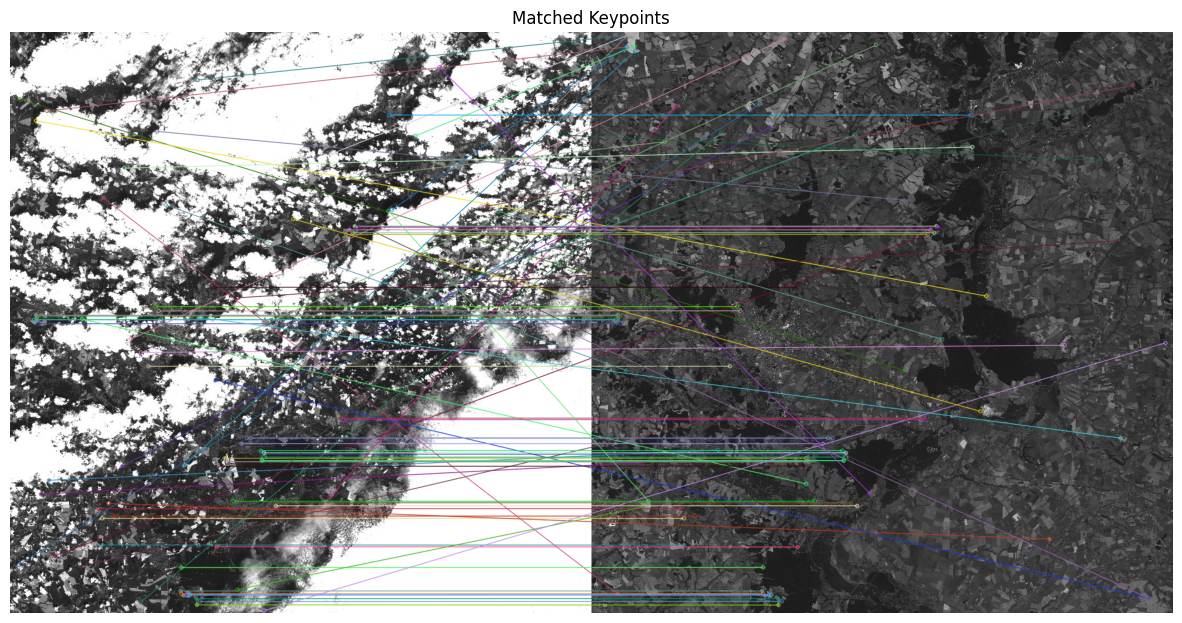

In [11]:
# Set the path to the tiled dataset for the two dates
tci_tiles_path1 = '/content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_dev_data/T36UYA_20190706T083611_TCI/'
tci_tiles_path2 = '/content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_dev_data/T36UYA_20190825T083601_TCI/'

# Image matching algorithm on the reconstructed TCI images
run_image_matching_on_reconstructed_tci(tci_tiles_path1, tci_tiles_path2)